In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
from spreg import OLS
import statsmodels.api as sm

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/hourly.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond_hourly.csv')

In [3]:
AQMS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Site      183960 non-null  object 
 1   Value     183960 non-null  float64
 2   DateTime  183960 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


In [4]:
Rd_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 209201 entries, 0 to 209200
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   fictitious  209201 non-null  object  
 1   identifier  209201 non-null  object  
 2   class       209201 non-null  object  
 3   roadNumber  32375 non-null   object  
 4   name1       172339 non-null  object  
 5   name1_lang  0 non-null       object  
 6   name2       0 non-null       object  
 7   name2_lang  0 non-null       object  
 8   formOfWay   209201 non-null  object  
 9   length      209201 non-null  int64   
 10  primary     209201 non-null  object  
 11  trunkRoad   209201 non-null  object  
 12  loop        209201 non-null  object  
 13  startNode   209201 non-null  object  
 14  endNode     209201 non-null  object  
 15  structure   93 non-null      object  
 16  nameTOID    172339 non-null  object  
 17  numberTOID  32375 non-null   object  
 18  function    2092

In [5]:
Gsp_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10021 entries, 0 to 10020
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   function   10021 non-null  object  
 1   distName1  2679 non-null   object  
 2   distName2  11 non-null     object  
 3   distName3  0 non-null      object  
 4   distName4  0 non-null      object  
 5   geometry   10021 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 469.9+ KB


In [6]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   siteid    21 non-null     object  
 1   sitename  21 non-null     object  
 2   geometry  21 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 632.0+ bytes


In [7]:
cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bp_mean   8760 non-null   float64
 1   tmp_mean  8760 non-null   float64
 2   rh_mean   8760 non-null   float64
 3   DateTime  8760 non-null   object 
dtypes: float64(3), object(1)
memory usage: 273.9+ KB


In [8]:
site_name=AQMS_df['Site'].unique().tolist()

In [9]:
AQMS_df.merge(cond,how='left',on='DateTime').corr()

,Value,bp_mean,tmp_mean,rh_mean
Value,1.000000,0.199784,-0.146961,0.052059
bp_mean,0.199784,1.000000,0.027207,-0.224058
tmp_mean,-0.146961,0.027207,1.000000,-0.570867
rh_mean,0.052059,-0.224058,-0.570867,1.000000


In [11]:
cond[['bp_mean','tmp_mean','rh_mean']].values

array([[1028.75      ,    9.58314999,   75.24258515],
       [1028.75      ,    9.58314999,   75.24258515],
       [1028.75      ,    9.58314999,   74.57591848],
       ...,
       [1025.75      ,    7.2       ,   93.        ],
       [1025.75      ,    6.        ,   94.66666667],
       [1025.25      ,    4.6       ,   95.        ]])

In [24]:
Y=AQMS_df['Value'].values
X=np.tile(cond[['bp_mean','tmp_mean','rh_mean']].values,(21,1))
print(X.shape,Y.shape)

(183960, 3) (183960,)


In [26]:
m_multi=sm.OLS(Y,X)
m_multi_fit=m_multi.fit()
m_multi_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                          8.103e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                        0.00
Time:                        08:40:41   Log-Likelihood:                     -6.9042e+05
No. Observations:              183960   AIC:                                  1.381e+06
Df Residuals:                  183957   BIC:                                  1.381e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0187      0.000    103.250      0.000       0.018       0.019
x2            -0.3361      0.005    -67.010      0.000      -0.346      -0.326
x3            -0.0385      0.002    -21.582      0.000      -0.042      -0.035
==============================================================================
Omnibus:                   234870.942   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        346510017.774
Skew:                           6.280   Prob(JB):                         0.00
Kurtosis:                     215.248   Cond. No.                         215.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)
loc_gdf.head()

,sitename,geometry,buffer_1km
siteid,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18..."


In [28]:
# Get all green spaces

Gsp=Gsp_gdf['geometry'].unary_union

In [29]:
# Set buffer zones for every road (50m)

Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)

In [30]:
# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [31]:
# Get all road buffer zones

Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [32]:
# Get all near-road green spaces

nRd_Gsp=Gsp.intersection(Rd_buffer)

In [33]:
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [34]:
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp))

21 21 21


In [35]:
loc_gdf['Road']=Rd_shp
loc_gdf['GreenSpace']=Gsp_shp
loc_gdf['NR_GreenSpace']=nRd_Gsp_shp
loc_gdf=loc_gdf.set_geometry('Road').set_geometry('GreenSpace').set_geometry('NR_GreenSpace')
loc_gdf

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace
siteid,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,..."
CT3,City of London - Sir John Cass School,POINT (533480.243 181186.837),"POLYGON ((534480.243 181186.837, 534475.427 18...",MULTILINESTRING Z ((533123.210 180253.779 0.00...,"MULTIPOLYGON Z (((534480.226 181186.502 0.000,...","MULTIPOLYGON Z (((534480.226 181186.502 0.000,..."
CR8,Croydon - Norbury Manor,POINT (530322.972 169553.770),"POLYGON ((531322.972 169553.770, 531318.157 16...",MULTILINESTRING Z ((530343.828 168554.795 0.00...,"MULTIPOLYGON Z (((530029.704 168597.897 0.000,...","MULTIPOLYGON Z (((530029.704 168597.897 0.000,..."
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,..."
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,..."


In [36]:
loc_gdf.dtypes

sitename           object
geometry         geometry
buffer_1km       geometry
Road             geometry
GreenSpace       geometry
NR_GreenSpace    geometry
dtype: object

In [37]:
london=gpd.read_file('data/london_boundary.shp')

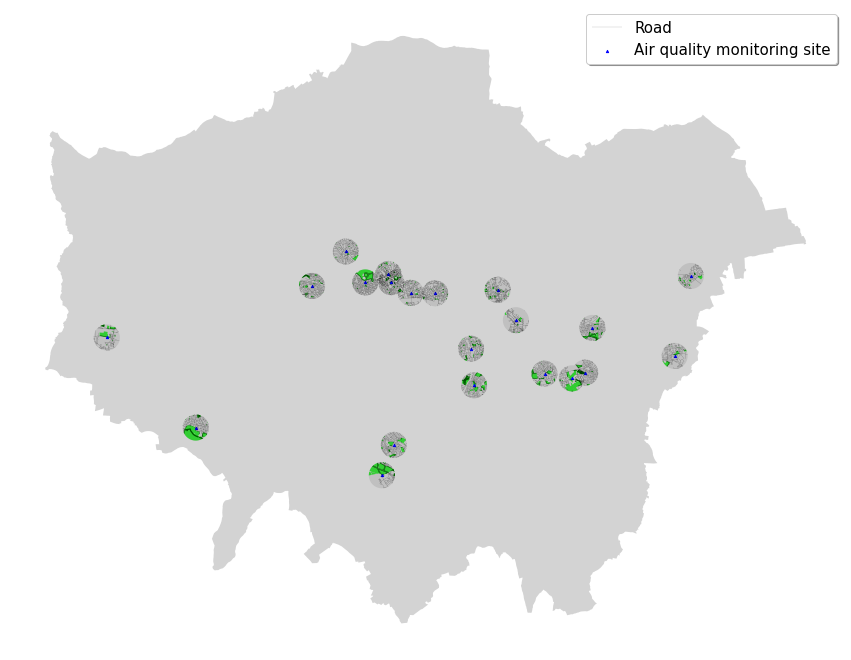

In [38]:
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

In [39]:
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [40]:
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis
siteid,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933


In [41]:
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.773266   9.996294 -3.3  4.8   7.8  12.425  92.4
CD9   8760.0  13.636306  10.394547 -7.3  7.2  11.0  16.300  83.9
GB0   8760.0  12.170311   8.973293 -1.2  6.8   9.5  14.000  79.8
GR4   8760.0  10.887170   9.774989 -2.7  5.3   8.2  12.300  97.6

In [ ]:
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [42]:
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [43]:
loc_gdf['pct_Gsp_area']=loc_gdf['GreenSpace'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nR_Gsp_area']=loc_gdf['NR_GreenSpace'].area/loc_gdf['buffer_area'] # percentage of near road gsp area

In [44]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21 entries, BX9 to MY7
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sitename         21 non-null     object  
 1   geometry         21 non-null     geometry
 2   buffer_1km       21 non-null     geometry
 3   Road             21 non-null     geometry
 4   GreenSpace       21 non-null     geometry
 5   NR_GreenSpace    21 non-null     geometry
 6   min_dis          21 non-null     float64 
 7   buffer_area      21 non-null     float64 
 8   pct_Gsp_area     21 non-null     float64 
 9   pct_nR_Gsp_area  21 non-null     float64 
dtypes: float64(4), geometry(5), object(1)
memory usage: 2.3+ KB


In [47]:
df=AQMS_df.merge(loc_gdf,left_on='Site',right_index=True)
df.drop(['sitename','geometry','buffer_1km','Road','GreenSpace','NR_GreenSpace','min_dis']
        ,axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   Value            183960 non-null  float64
 2   DateTime         183960 non-null  object 
 3   buffer_area      183960 non-null  float64
 4   pct_Gsp_area     183960 non-null  float64
 5   pct_nR_Gsp_area  183960 non-null  float64
dtypes: float64(4), object(2)
memory usage: 9.8+ MB


In [48]:
df=df.merge(cond,on='DateTime')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   Value            183960 non-null  float64
 2   DateTime         183960 non-null  object 
 3   buffer_area      183960 non-null  float64
 4   pct_Gsp_area     183960 non-null  float64
 5   pct_nR_Gsp_area  183960 non-null  float64
 6   bp_mean          183960 non-null  float64
 7   tmp_mean         183960 non-null  float64
 8   rh_mean          183960 non-null  float64
dtypes: float64(7), object(2)
memory usage: 14.0+ MB


In [58]:
df['DateTime']=pd.to_datetime(df['DateTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Site             183960 non-null  object        
 1   Value            183960 non-null  float64       
 2   DateTime         183960 non-null  datetime64[ns]
 3   buffer_area      183960 non-null  float64       
 4   pct_Gsp_area     183960 non-null  float64       
 5   pct_nR_Gsp_area  183960 non-null  float64       
 6   bp_mean          183960 non-null  float64       
 7   tmp_mean         183960 non-null  float64       
 8   rh_mean          183960 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 14.0+ MB


In [71]:
df['month']=df['DateTime'].dt.month

In [74]:
df.dtypes

Site                       object
Value                     float64
DateTime           datetime64[ns]
buffer_area               float64
pct_Gsp_area              float64
pct_nR_Gsp_area           float64
bp_mean                   float64
tmp_mean                  float64
rh_mean                   float64
month                       int64
dtype: object

In [75]:
df['month'].isin([2,3,4])

0         False
1         False
2         False
3         False
4         False
          ...  
183955    False
183956    False
183957    False
183958    False
183959    False
Name: month, Length: 183960, dtype: bool

In [76]:
high=df[df['month'].isin([2,3,4])].copy()
high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44856 entries, 504 to 170351
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Site             44856 non-null  object        
 1   Value            44856 non-null  float64       
 2   DateTime         44856 non-null  datetime64[ns]
 3   buffer_area      44856 non-null  float64       
 4   pct_Gsp_area     44856 non-null  float64       
 5   pct_nR_Gsp_area  44856 non-null  float64       
 6   bp_mean          44856 non-null  float64       
 7   tmp_mean         44856 non-null  float64       
 8   rh_mean          44856 non-null  float64       
 9   month            44856 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 3.8+ MB


In [77]:
vars=['pct_Gsp_area','pct_nR_Gsp_area','bp_mean','tmp_mean','rh_mean']
Y=high['Value'].values
X=high[vars].values
m_con=sm.OLS(Y,X)
m_con_fit=m_con.fit()
print(m_con_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.576
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                          1.219e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                        0.00
Time:                        16:35:51   Log-Likelihood:                     -1.8228e+05
No. Observations:               44856   AIC:                                  3.646e+05
Df Residuals:                   44851   BIC:                                  3.646e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [78]:
from sklearn.linear_model import LinearRegression

reg=LinearRegression().fit(X,Y)
reg.score(X,Y)

0.05207088679208671

In [80]:
high.corr().round(3)

,Value,buffer_area,pct_Gsp_area,pct_nR_Gsp_area,bp_mean,tmp_mean,rh_mean,month
Value,1.000,-0.032,-0.006,0.008,0.214,-0.095,0.037,0.026
buffer_area,-0.032,1.000,0.346,0.225,0.068,-0.064,0.025,-0.069
pct_Gsp_area,-0.006,0.346,1.000,0.848,-0.000,0.000,0.000,0.000
pct_nR_Gsp_area,0.008,0.225,0.848,1.000,-0.000,-0.000,0.000,0.000
bp_mean,0.214,0.068,-0.000,-0.000,1.000,-0.102,-0.124,-0.220
tmp_mean,-0.095,-0.064,0.000,-0.000,-0.102,1.000,-0.669,0.117
rh_mean,0.037,0.025,0.000,0.000,-0.124,-0.669,1.000,-0.150
month,0.026,-0.069,0.000,0.000,-0.220,0.117,-0.150,1.000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 0 to 183959
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   Value            183960 non-null  float64
 2   DateTime         183960 non-null  object 
 3   buffer_area      183960 non-null  float64
 4   pct_Gsp_area     183960 non-null  float64
 5   pct_nR_Gsp_area  183960 non-null  float64
 6   bp_mean          183960 non-null  float64
 7   tmp_mean         183960 non-null  float64
 8   rh_mean          183960 non-null  float64
dtypes: float64(7), object(2)
memory usage: 14.0+ MB


In [81]:
daily=pd.read_csv('data/daily.csv')
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7665 entries, 0 to 7664
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  7665 non-null   object 
 1   Value     7665 non-null   float64
 2   Site      7665 non-null   object 
dtypes: float64(1), object(2)
memory usage: 179.8+ KB


In [84]:
cond_daily=pd.read_csv('data/cond_daily.csv')
cond_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  365 non-null    object 
 1   bp_mean   365 non-null    float64
 2   tmp_mean  365 non-null    float64
 3   rh_mean   365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [85]:
daily_df=daily.merge(cond_daily,on='DateTime')
daily_df=daily_df.merge(loc_gdf,left_on='Site',right_index=True)
daily_df.drop(['sitename','geometry','buffer_1km','Road','GreenSpace','NR_GreenSpace','min_dis']
        ,axis=1,inplace=True)
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7665 entries, 0 to 7664
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         7665 non-null   object 
 1   Value            7665 non-null   float64
 2   Site             7665 non-null   object 
 3   bp_mean          7665 non-null   float64
 4   tmp_mean         7665 non-null   float64
 5   rh_mean          7665 non-null   float64
 6   buffer_area      7665 non-null   float64
 7   pct_Gsp_area     7665 non-null   float64
 8   pct_nR_Gsp_area  7665 non-null   float64
dtypes: float64(7), object(2)
memory usage: 598.8+ KB


In [86]:
daily_df['DateTime']=pd.to_datetime(daily_df['DateTime'])

In [87]:
daily_df.corr()

,Value,bp_mean,tmp_mean,rh_mean,buffer_area,pct_Gsp_area,pct_nR_Gsp_area
Value,1.000000,2.404436e-01,-1.396962e-01,-5.041142e-02,-0.039560,-1.329513e-02,1.267480e-04
bp_mean,0.240444,1.000000e+00,5.244268e-02,-3.622951e-01,-0.001407,1.019764e-14,1.807044e-15
tmp_mean,-0.139696,5.244268e-02,1.000000e+00,-4.161895e-01,0.000804,1.896323e-16,6.791586e-17
rh_mean,-0.050411,-3.622951e-01,-4.161895e-01,1.000000e+00,0.002579,-2.898289e-15,-1.005143e-15
buffer_area,-0.039560,-1.407013e-03,8.039049e-04,2.578953e-03,1.000000,3.756169e-01,2.776423e-01
pct_Gsp_area,-0.013295,1.019764e-14,1.896323e-16,-2.898289e-15,0.375617,1.000000e+00,8.479318e-01
pct_nR_Gsp_area,0.000127,1.807044e-15,6.791586e-17,-1.005143e-15,0.277642,8.479318e-01,1.000000e+00


In [ ]:
df=AQMS_df.drop(AQMS_df[AQMS_df['Site'].isin(['BL0','GR4'])].index).reset_index(drop=True)
df.info()

In [ ]:
df.groupby('Site').describe()

In [ ]:
df=df.merge(loc_gdf,left_on='Site',right_index=True)
df

In [ ]:
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

In [ ]:
loc_gdf.head()

In [ ]:
df.head()

In [ ]:
cond.head()

In [ ]:
df=df.merge(cond,on='DateTime')
df.head()

In [ ]:
df.info()

In [ ]:
loc_gdf.info()

In [ ]:
df=df.merge(loc_gdf,left_on='Site',right_index=True)
df.info()

In [ ]:
var=['pct_Gsp_area','pct_nR_Gsp_area','BP','Tmp','RH']